# Forecasting con Modelo ARIMA 

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


from math import sqrt

import matplotlib
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importar datos

In [2]:
df_data = pd.read_csv("arima_data.csv")
df_data.columns = ['Date', 'Lactose', 'Whey_central', 'Whey_west']
df_data['Date'] = pd.to_datetime(df_data['Date'])
df_data = df_data.sort_values(by='Date', ascending=True)
df_data = df_data.reset_index(drop=True)
df_data

,Date,Lactose,Whey_central,Whey_west
0,1996-01-01,0.167488,0.2800,0.2550
1,1996-01-08,0.167488,0.2750,0.2550
2,1996-01-15,0.167488,0.2625,0.2525
3,1996-01-22,0.167488,0.2475,0.2525
4,1996-01-29,0.167488,0.2350,0.2525
...,...,...,...,...
1431,2023-08-07,0.197044,0.2500,2.9500
1432,2023-08-14,0.206897,0.2525,0.3100
1433,2023-08-21,0.206897,0.2525,0.3200
1434,2023-08-28,0.221675,0.2700,0.3400


In [3]:
atri = 'Lactose'
atribs = ['Date', atri]
df = df_data.copy()
df = df[atribs]
df.head()

,Date,Lactose
0,1996-01-01,0.167488
1,1996-01-08,0.167488
2,1996-01-15,0.167488
3,1996-01-22,0.167488
4,1996-01-29,0.167488


In [4]:
df.describe()

,Lactose
count,1436.000000
mean,0.331664
std,0.186372
min,0.125616
25%,0.197044
50%,0.256158
75%,0.408867
max,1.000000


In [6]:
print('Fecha de inicio: {}\nFecha final: {}'.format(df.Date.min(),df.Date.max()))

Fecha de inicio: 1996-01-01 00:00:00
Fecha final: 2023-09-04 00:00:00


In [7]:
df.columns

Index(['Date', 'Lactose'], dtype='object')

In [8]:
df.shape

(1436, 2)

# Visualización de datos

__Converting to datetime format:__

In [9]:
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

__Setting index as the datetime column for easier manipulations:__

In [10]:
y = df.set_index('Date')

In [11]:
y.index

DatetimeIndex(['1996-01-01', '1996-01-08', '1996-01-15', '1996-01-22',
               '1996-01-29', '1996-02-05', '1996-02-12', '1996-02-19',
               '1996-02-26', '1996-03-04',
               ...
               '2023-07-03', '2023-07-10', '2023-07-15', '2023-07-24',
               '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21',
               '2023-08-28', '2023-09-04'],
              dtype='datetime64[ns]', name='Date', length=1436, freq=None)

In [12]:
y

,Lactose
Date,
1996-01-01,0.167488
1996-01-08,0.167488
1996-01-15,0.167488
1996-01-22,0.167488
1996-01-29,0.167488
...,...
2023-08-07,0.197044
2023-08-14,0.206897
2023-08-21,0.206897


In [13]:
y.isnull().sum()

Lactose    0
dtype: int64

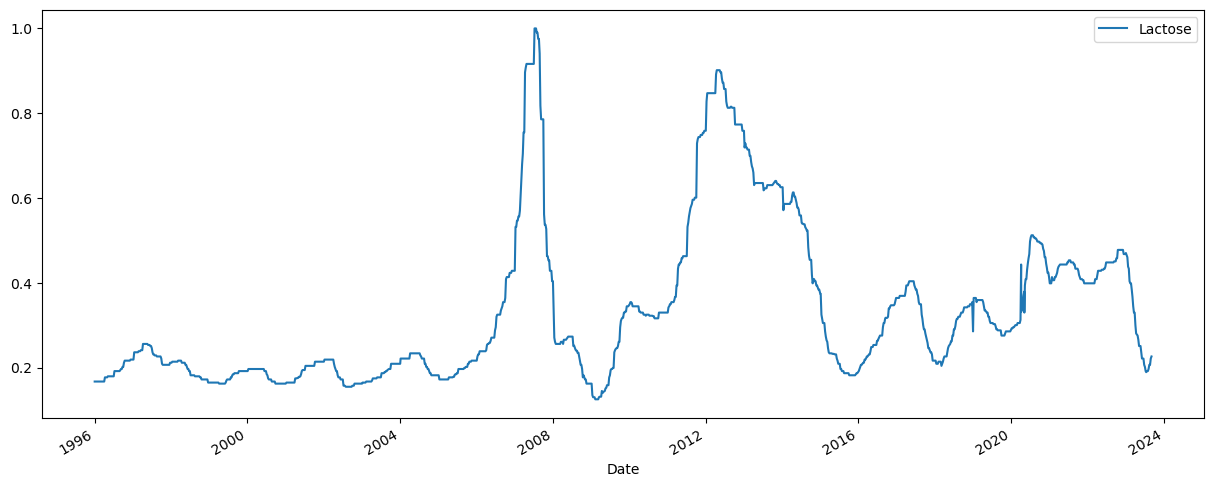

In [14]:
y.plot(figsize=(15, 6))
plt.show()

__Gráfica de distribución:__

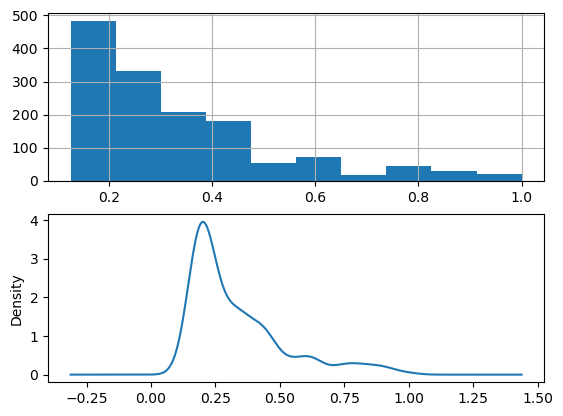

In [15]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y[atri].hist()
pyplot.subplot(212)
y[atri].plot(kind='kde')
pyplot.show()

__Descomposición usando statsmodel:__
- Se deconstruye una serie de tiempo en varios componentes: tendencia, estacionales y residuales o ruido.

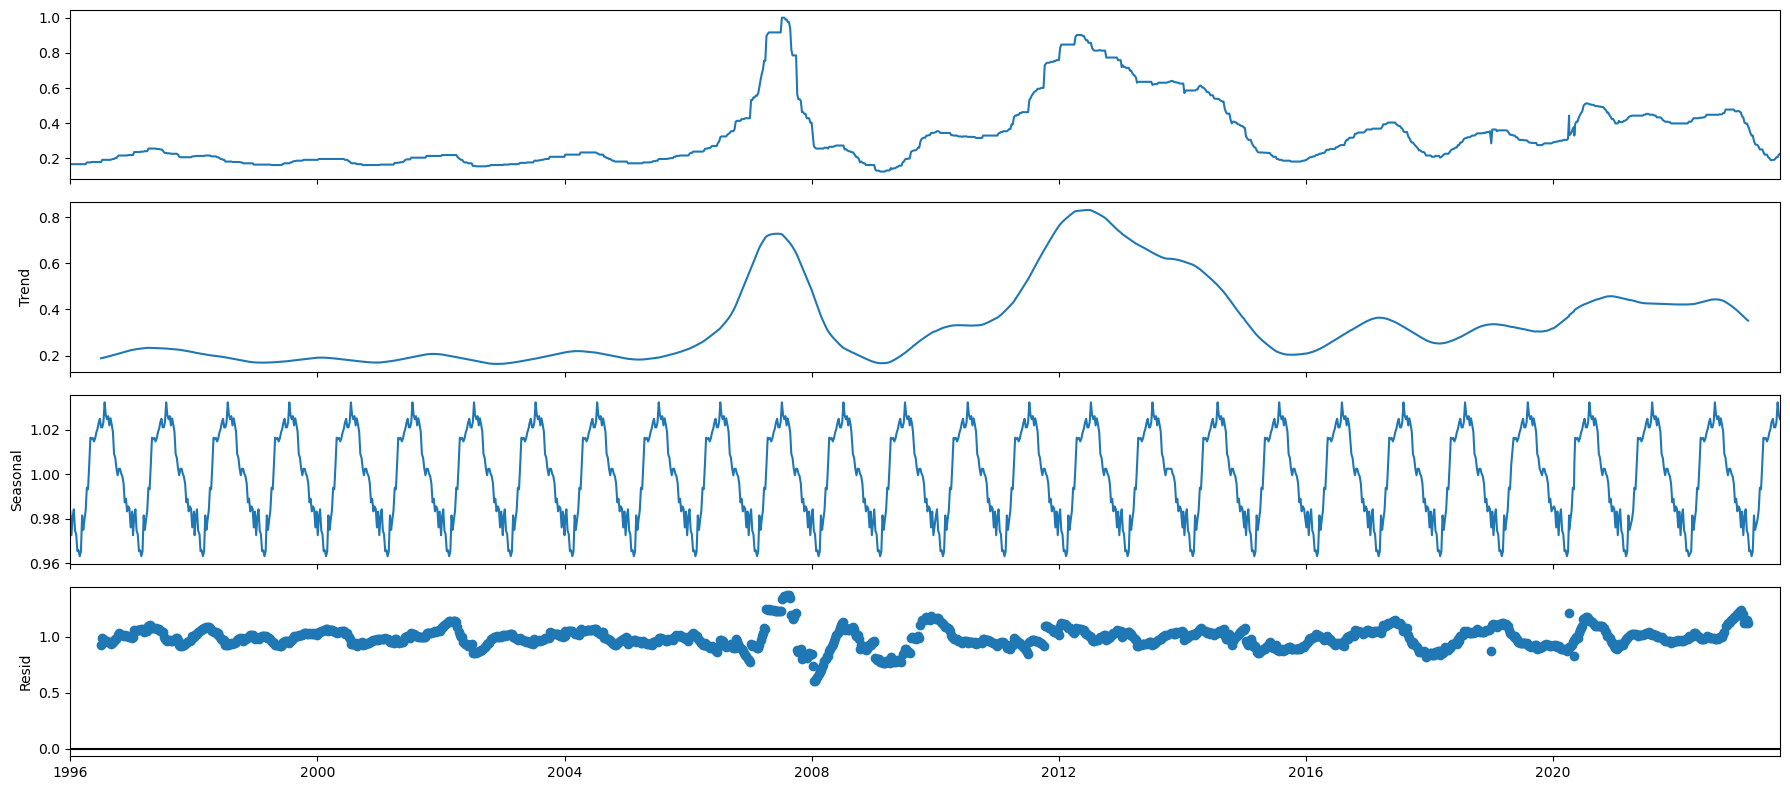

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', period = 52)
fig = decomposition.plot()
plt.show()

## Estacionariedad
- Una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, permanecen constantes en el tiempo. 

In [31]:
def test_stationarity(timeseries):
    
    # Determinar media movil y desviación estandar movil
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    # Graficar estadística movil:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media movil')
    std = plt.plot(rolstd, color='black', label = 'Std movil')
    plt.legend(loc='best')
    plt.title('Media y desviación estandar móvil')
    plt.show(block=False)
    
    # Prueba de Dickey-Fuller:
    print ('Resultado de prueba Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadística de prueba','p-value','#Lags Usados','Numero de observaciones usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print (dfoutput)

__Podemos verificar la estacionariedad usando lo siguiente:__

- __Gráficas ACF y PACF__: si la serie de tiempo es estacionaria, las gráficas ACF y PACF mostrarán una __disminución rápida en la correlación__después de una pequeña cantidad de retraso entre los puntos.
- __Proporcionar estadísticas móviles__: podemos trazar la media móvil o la varianza móvil y ver si varía con el tiempo. La media móvil / varianza es para cualquier instante "t", la media / varianza del último año, es decir, los últimos 12 meses.
- __Prueba Dickey-Fuller aumentada:__ Se usa para comprobar la estacionariedad.Se tiene como hipótesis nula que la serie de tiempo no es estacionaria. Los resultados de la prueba abordan una estadística de prueba y algunos valores críticos para los niveles de confianza de diferencia. Si la "estadística de prueba" es menor que el "valor crítico", se puede rechazar la hipótesis nula y decir que la serie es estacionaria

### Gráficas ACF y PACF

- Repasemos los gráficos de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF)
- Si la serie de tiempo es estacionaria, las gráficas ACF / PACF mostrarán una rápida caída en la correlación después de algunos puntos.
- Estos datos no son estacionarios ya que un gran número de observaciones previas se correlacionan con valores futuros.
- La autocorrelación parcial  es la correlación que resulta después de eliminar el efecto de cualquier correlación debido a los términos en rezagos más cortos.

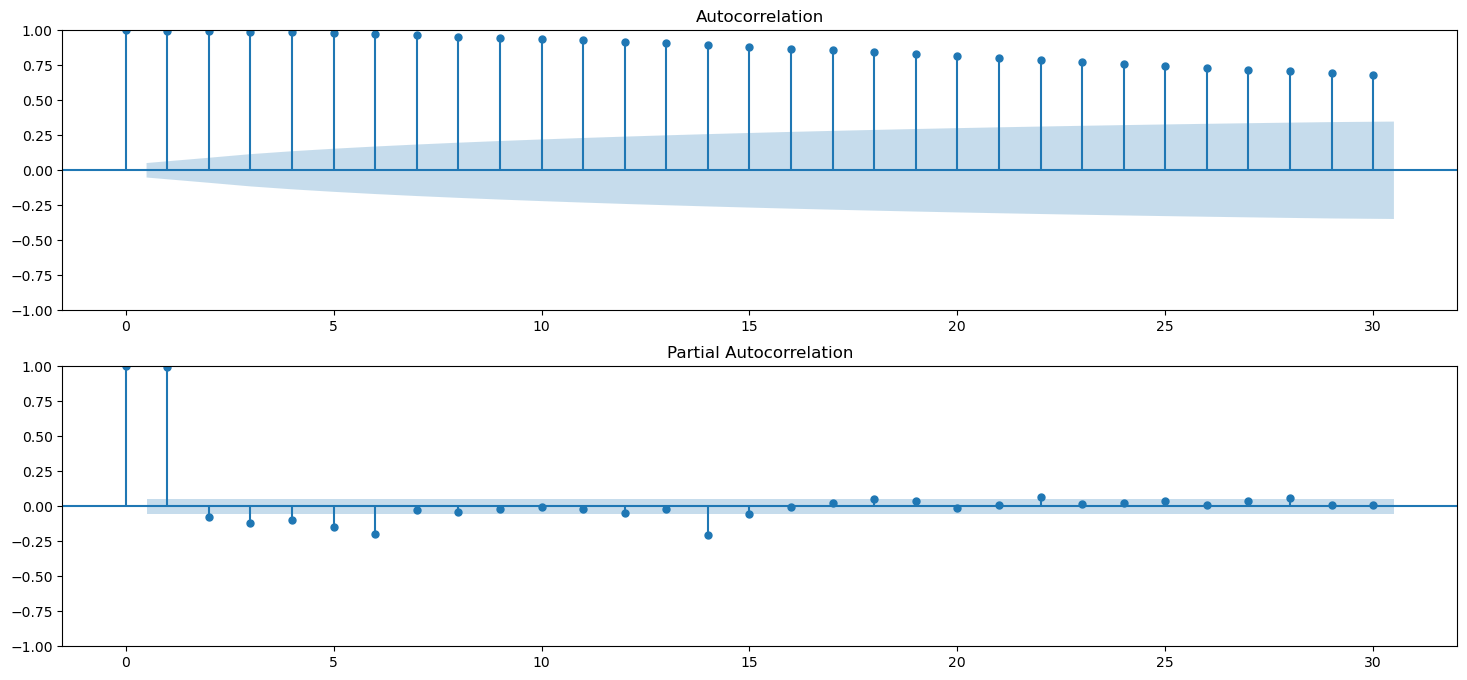

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y[atri], ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y[atri], ax=pyplot.gca(), lags = 30)
pyplot.show()

### Estadística continua
- Se observa que la media móvil y la desviación estándar no son constantes con respecto al tiempo (son oscilante), notando que la desviación estandar no varía en gran medida.
- Por tanto, la serie temporal no es estacionaria

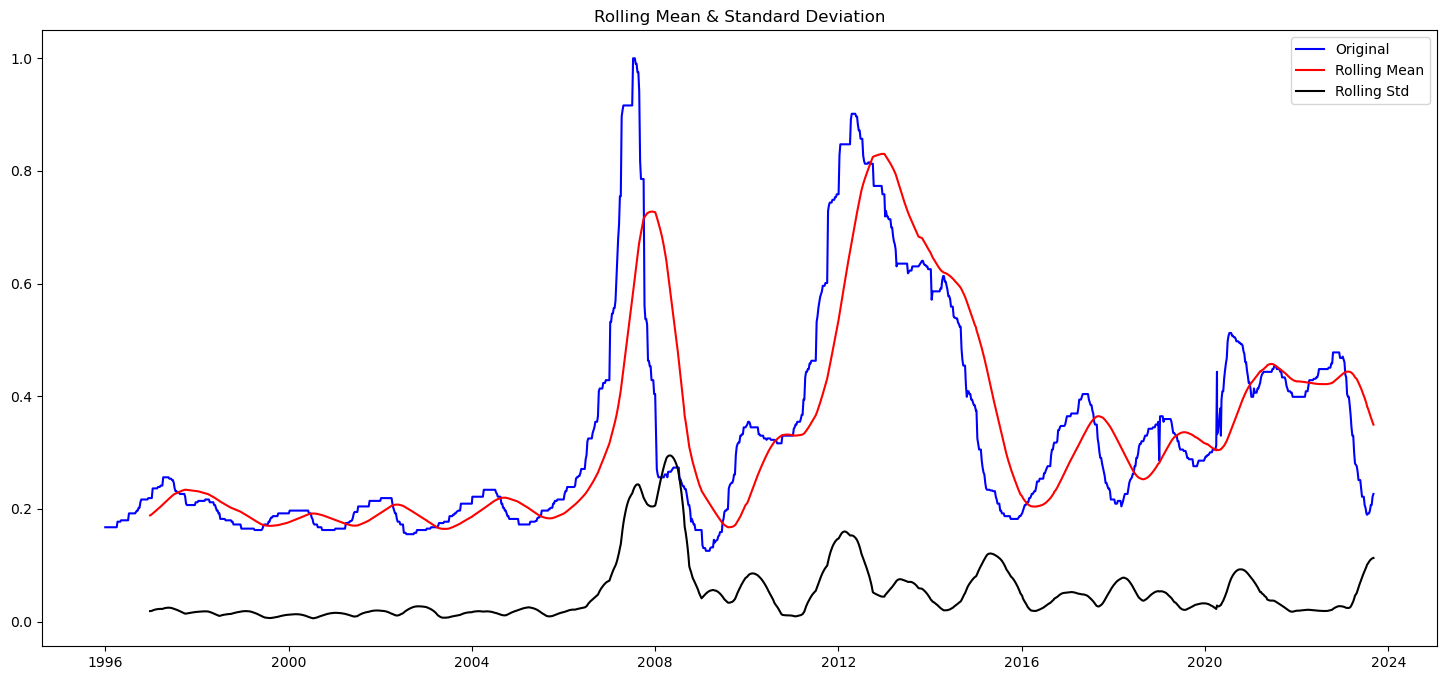

In [26]:
# Estadística continua
rolmean = y.rolling(52).mean()
rolstd = y.rolling(52).std()

# Gráficas
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


### Prueba Dickey-Fuller 

- Hipótesis nula: la serie temporal no es estacionaria
- Rechazar la hipótesis nula indicará estacionaridad (es decir, un valor p muy bajo) 

In [27]:
from statsmodels.tsa.stattools import adfuller

In [30]:
#Perform Dickey-Fuller test:
print ('Prueba de Dickey-Fuller:')
dftest = adfuller(y[atri], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Estadística de prueba','p-value','#Lags usados','Número de observaciones usadas'])
for key,value in dftest[4].items():
    dfoutput['Varlor crítico (%s)'%key] = value
print (dfoutput)

Prueba de Dickey-Fuller:
Estadística de prueba               -3.330382
p-value                              0.013574
#Lags usados                        21.000000
Número de observaciones usadas    1414.000000
Varlor crítico (1%)                 -3.434983
Varlor crítico (5%)                 -2.863586
Varlor crítico (10%)                -2.567859
dtype: float64


## Hacer que las series temporales sean estacionarias
Hay 2 razones principales detrás de la no estacionariedad de un TS:

1. __Tendencia__ - media variable con el tiempo. Por ejemplo, en este caso vimos, el precio oscila en el tiempo.
2. __Estacionalidad__: variaciones en períodos de tiempo específicos, por ejemplo, en épocas o estaciones con escasez de alimentos

### Transformaciones
- Se pueden aplicar transformaciones que penalicen más a los valores más altos que a los más pequeños. Estos pueden tomar un registro, una raíz cuadrada, una raíz cúbica, etc.

#### Log Scale Transformation

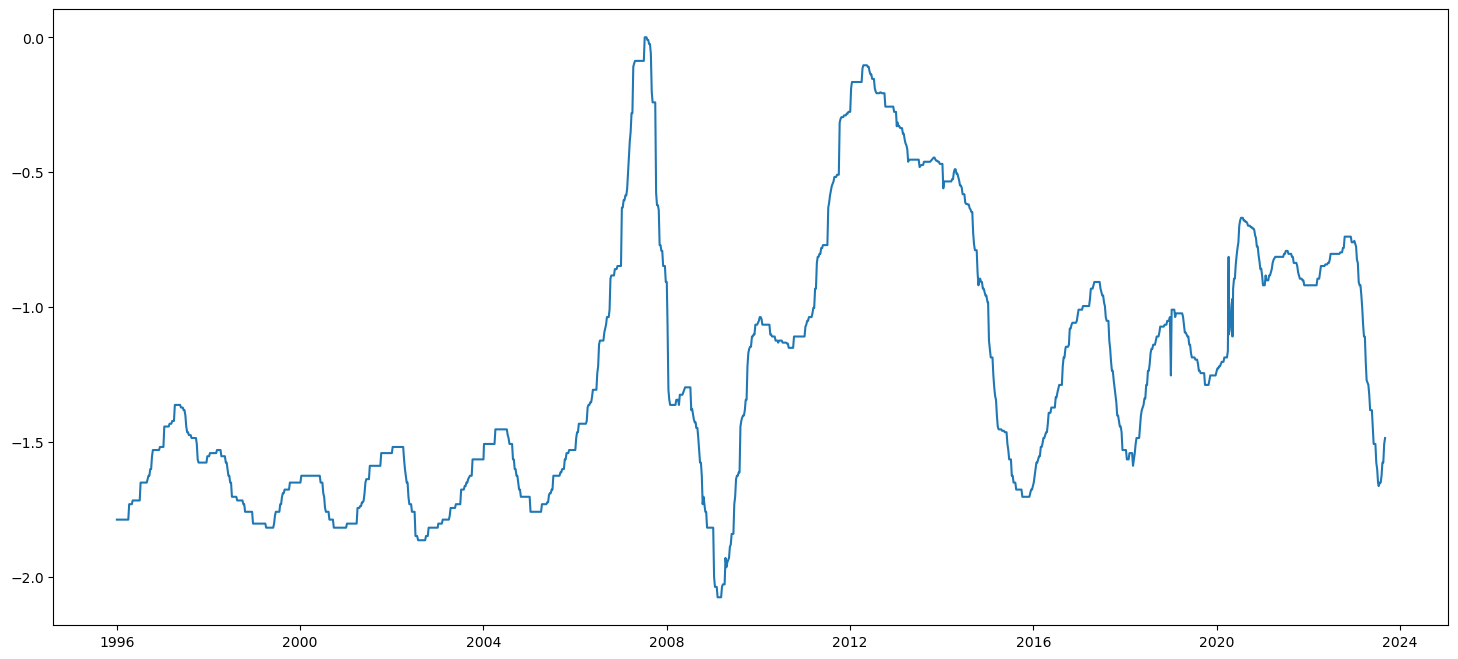

In [32]:
ts_log = np.log(y)
plt.plot(ts_log)

### Técnicas para eliminar Tendencia - Suavizado
- Suavizar es tomar promedios móviles en ventanas de tiempo

#### Media móvil
- Se toma un promedio de "k" valores consecutivos dependiendo de la frecuencia de las series de tiempo.
- Aquí se puede tomar el promedio del último año, es decir, los últimos 12 valores.
- Un inconveniente de este enfoque es que el período de tiempo debe definirse estrictamente.

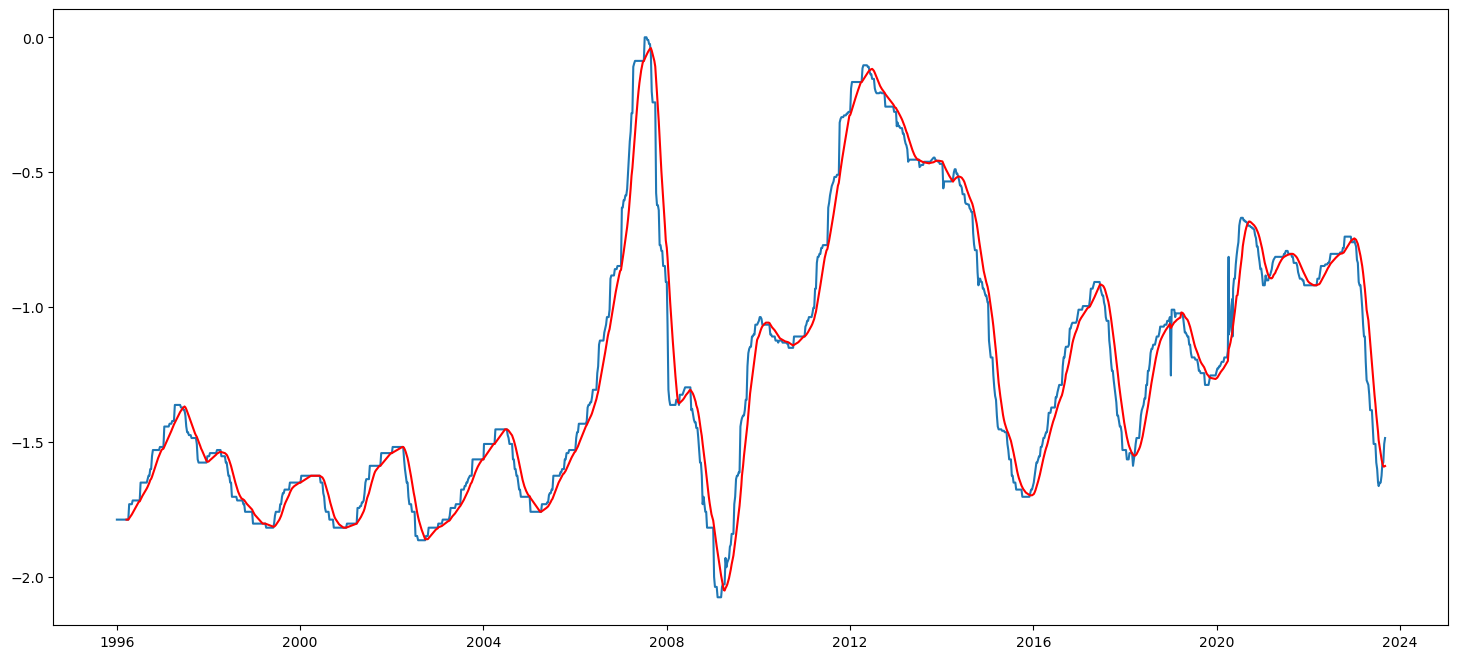

In [35]:
moving_avg = ts_log.rolling(12).mean()

plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [36]:
ts_log_moving_avg_diff = ts_log[atri] - moving_avg[atri]
ts_log_moving_avg_diff.head(12)

Date
1996-01-01    NaN
1996-01-08    NaN
1996-01-15    NaN
1996-01-22    NaN
1996-01-29    NaN
1996-02-05    NaN
1996-02-12    NaN
1996-02-19    NaN
1996-02-26    NaN
1996-03-04    NaN
1996-03-11    NaN
1996-03-18    0.0
Name: Lactose, dtype: float64

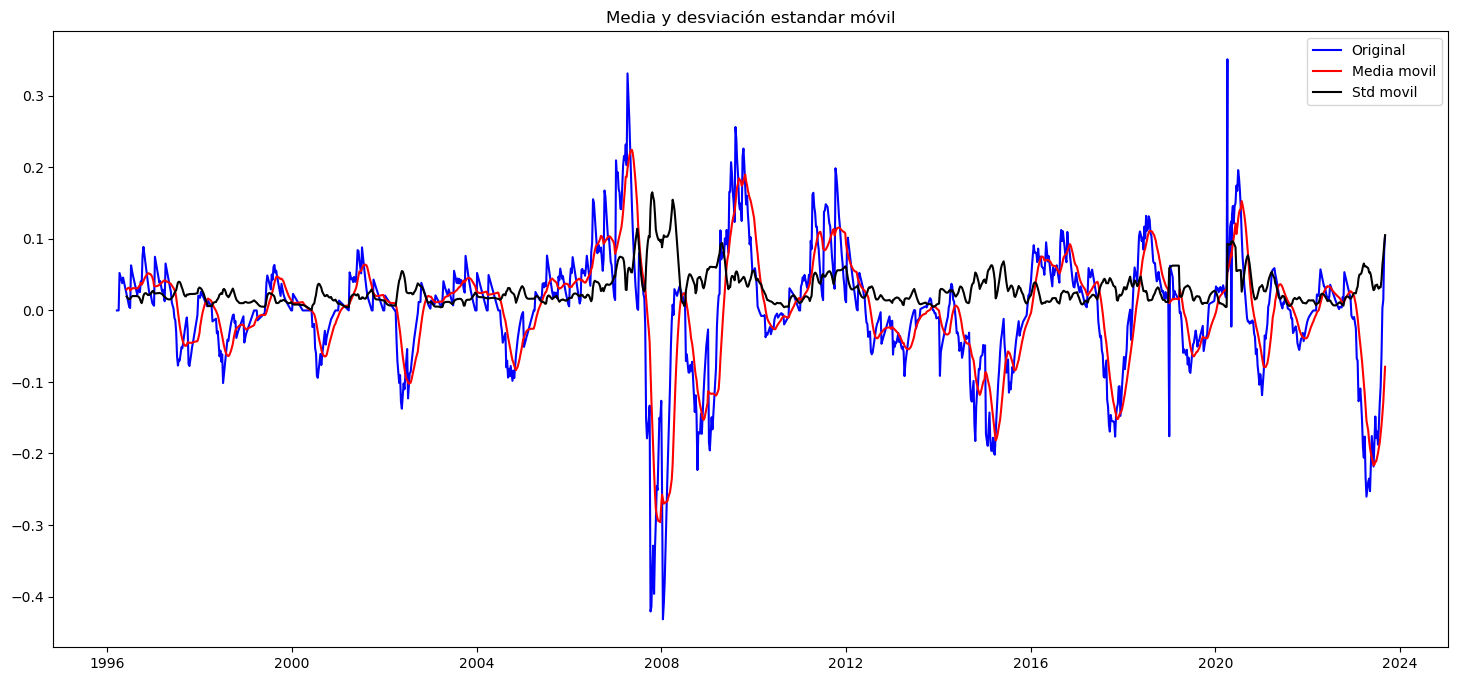

Resultado de prueba Dickey-Fuller:
Estadística de prueba            -7.196935e+00
p-value                           2.420922e-10
#Lags Usados                      1.500000e+01
Numero de observaciones usadas    1.409000e+03
Valor crítico (1%)               -3.435000e+00
Valor crítico (5%)               -2.863593e+00
Valor crítico (10%)              -2.567863e+00
dtype: float64


In [37]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Media móvil ponderada exponencialmente:
- Para abordar el problema de elegir una ventana definida en la media móvil, se puede utilizar la media móvil ponderada exponencial
- Se toma un "promedio móvil ponderado" donde los valores más recientes reciben un peso más alto.
- Un método popular es el promedio móvil ponderado exponencialmente donde se asignan pesos a todos los valores anteriores con un factor de disminución.

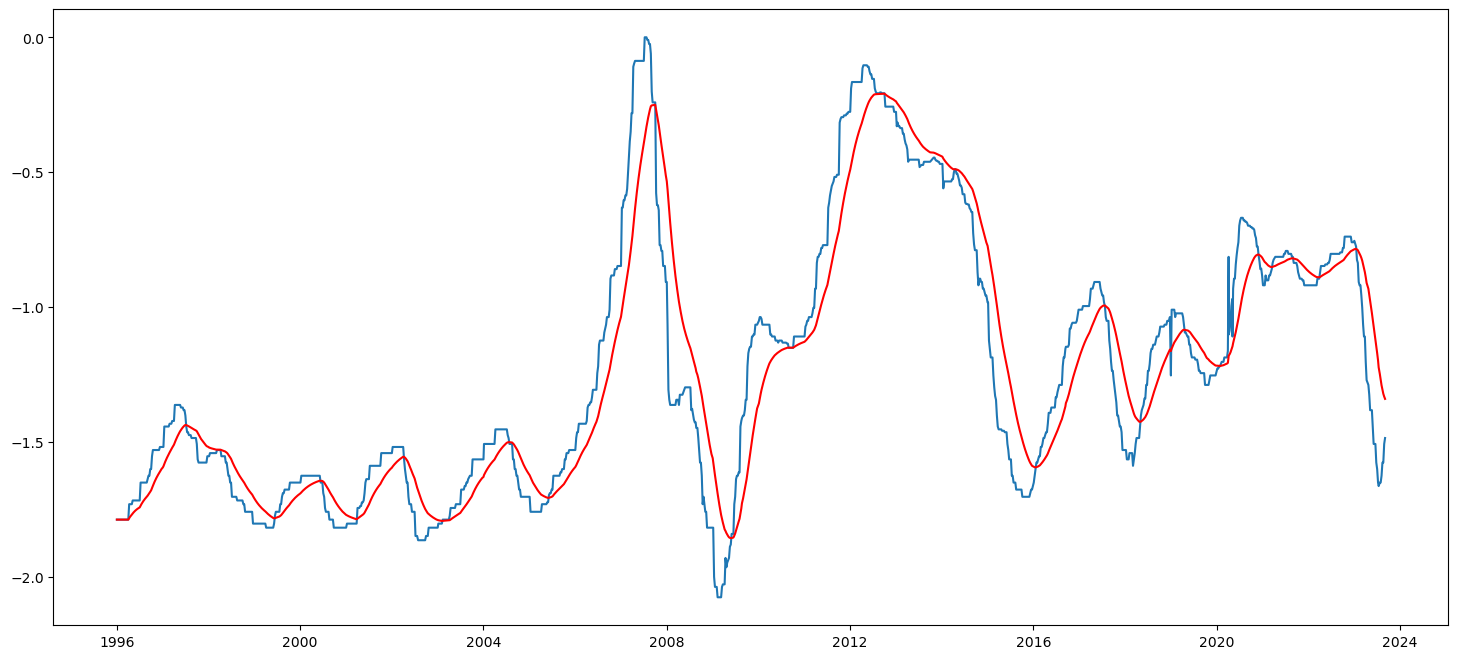

In [38]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

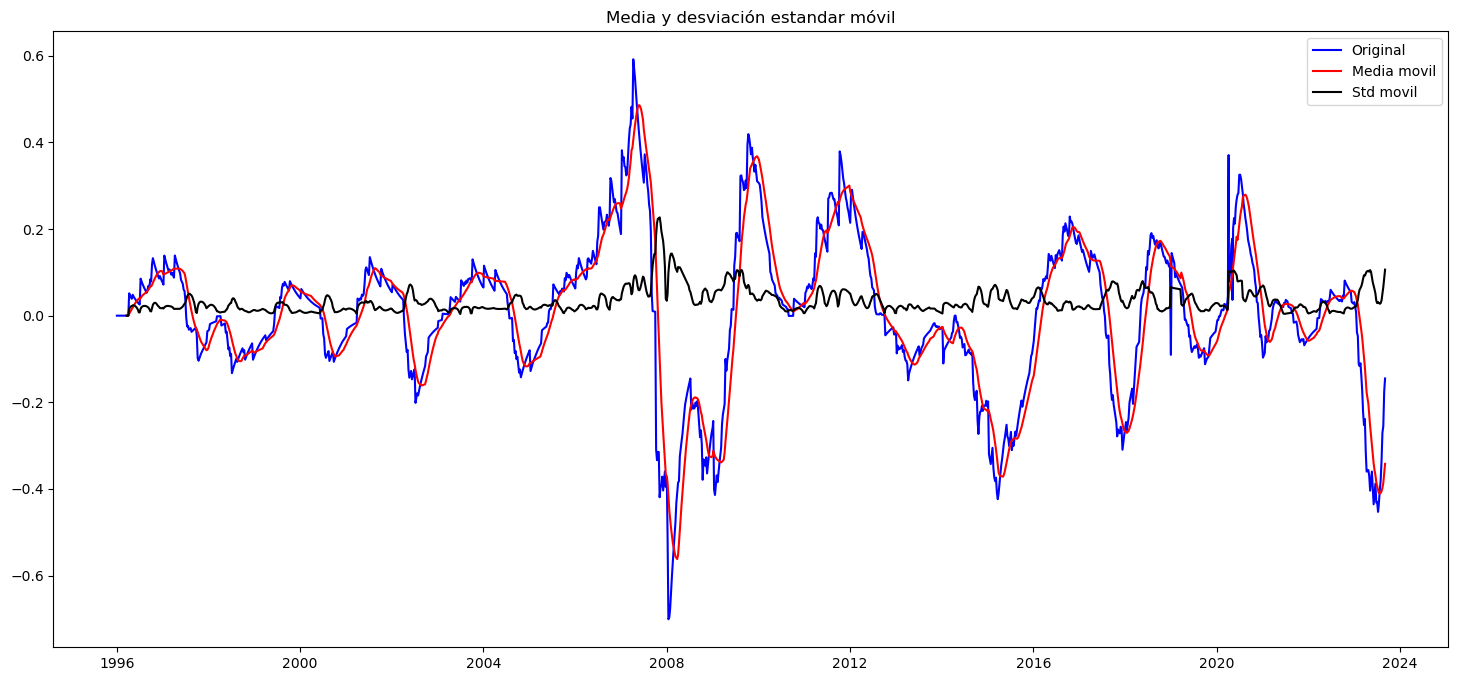

Resultado de prueba Dickey-Fuller:
Estadística de prueba            -7.148626e+00
p-value                           3.183945e-10
#Lags Usados                      1.400000e+01
Numero de observaciones usadas    1.421000e+03
Valor crítico (1%)               -3.434960e+00
Valor crítico (5%)               -2.863576e+00
Valor crítico (10%)              -2.567854e+00
dtype: float64


In [39]:
ts_log_ewma_diff = ts_log[atri] - expwighted_avg[atri]
test_stationarity(ts_log_ewma_diff)

#### Diferenciación
- En esta técnica, se toma la diferencia de la observación en un instante particular con la del instante anterior.


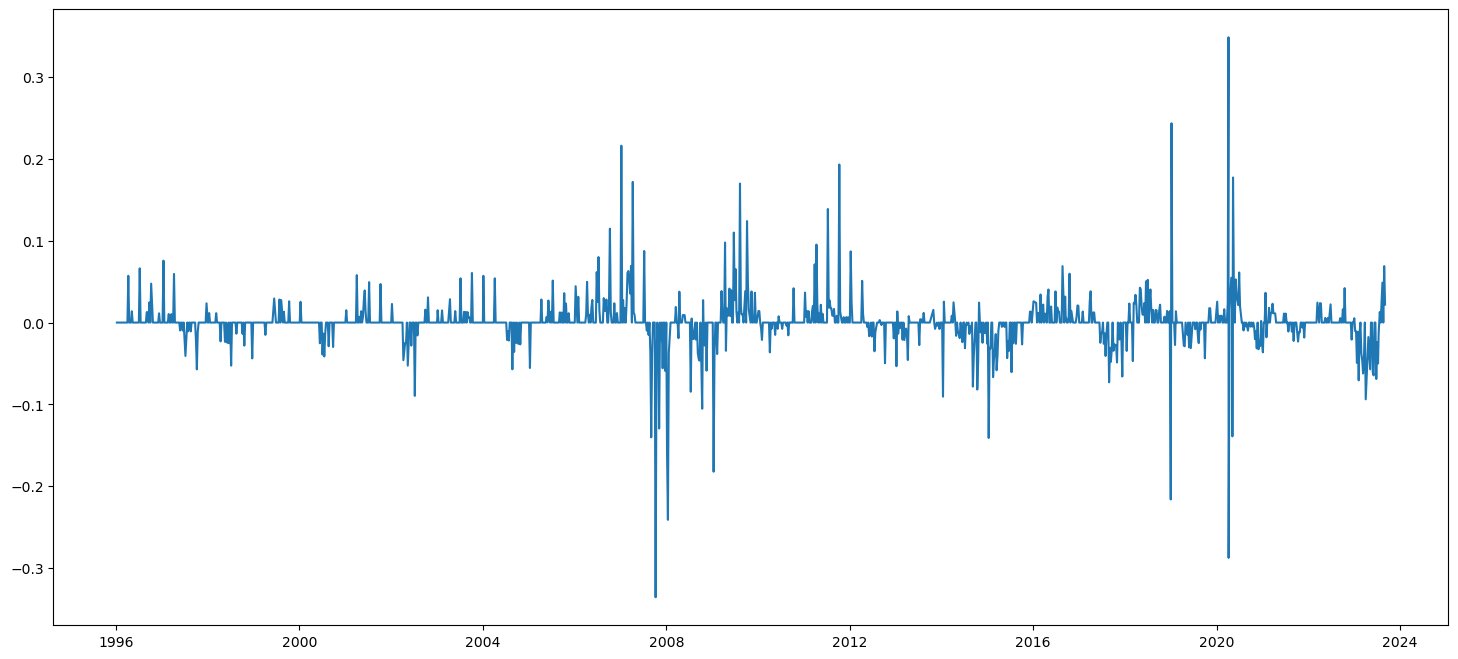

In [40]:
ts_log_diff = ts_log[atri] - ts_log[atri].shift()
plt.plot(ts_log_diff)

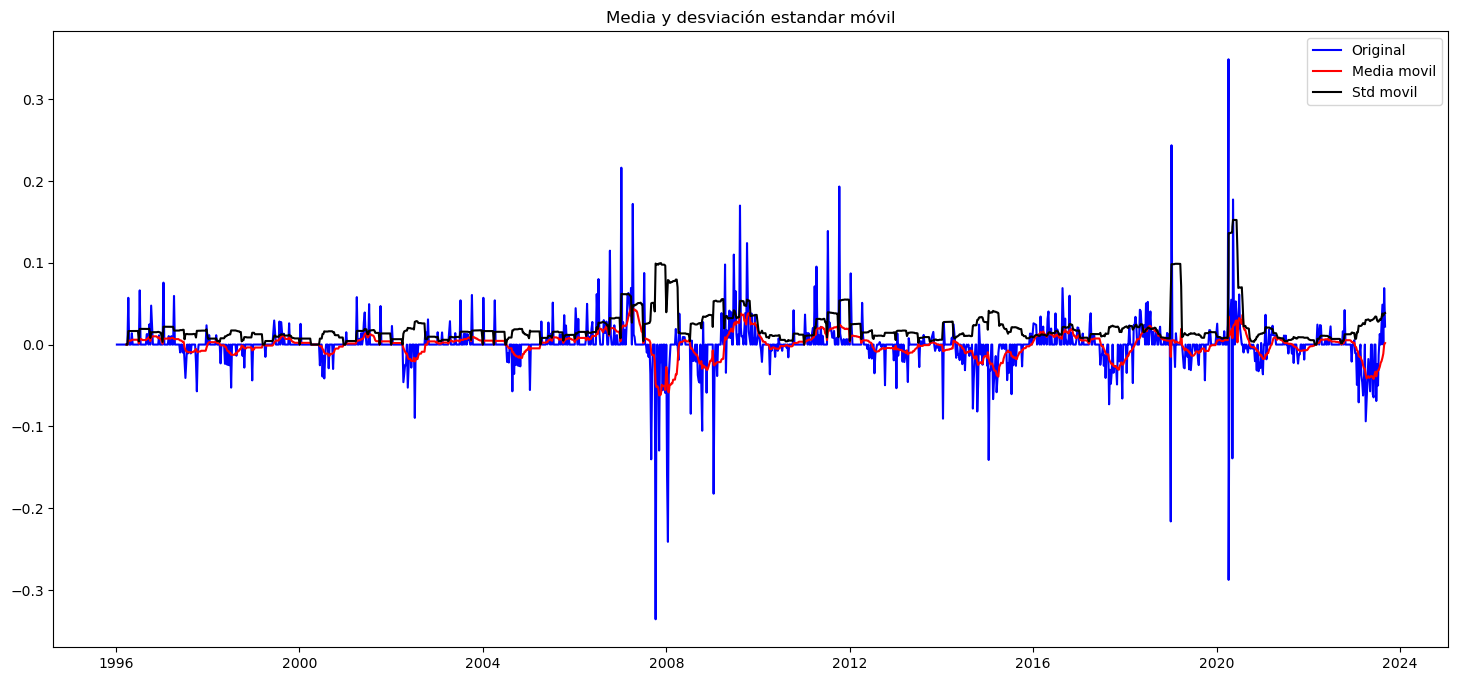

Resultado de prueba Dickey-Fuller:
Estadística de prueba            -7.039059e+00
p-value                           5.911509e-10
#Lags Usados                      2.300000e+01
Numero de observaciones usadas    1.411000e+03
Valor crítico (1%)               -3.434993e+00
Valor crítico (5%)               -2.863591e+00
Valor crítico (10%)              -2.567862e+00
dtype: float64


In [41]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Descomposición
- En este enfoque, tanto la tendencia como la estacionalidad se modelan por separado y se devuelve la parte restante de la serie.

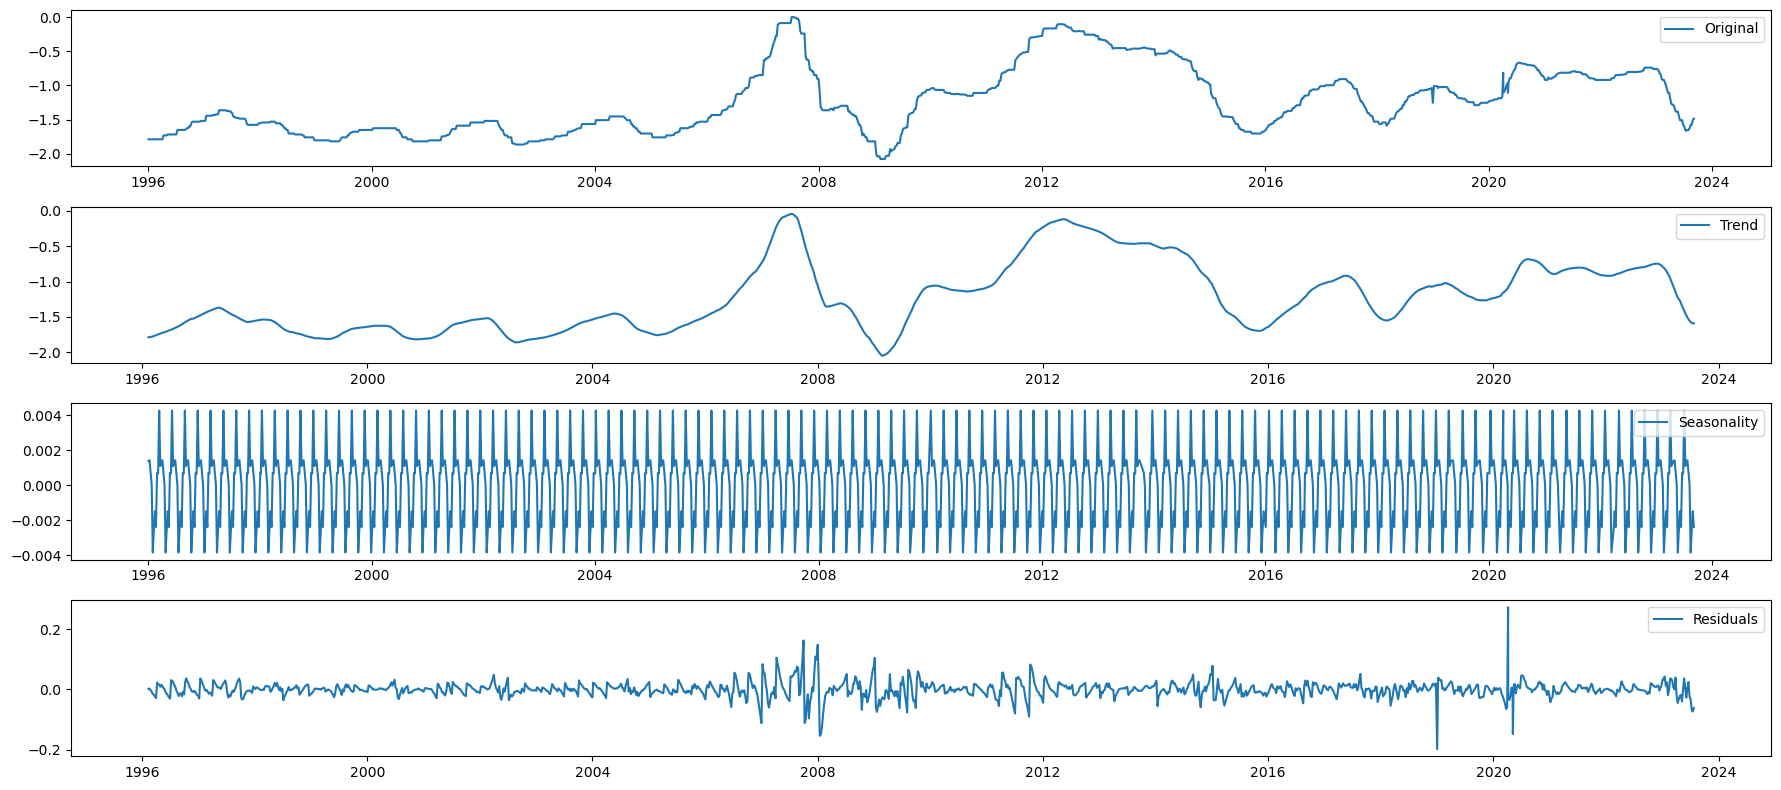

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, period = 12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Predicción de Series Temporales


## Autoregresión (AR)
- El método de autorregresión (AR) modela el siguiente paso de la secuencia como una función lineal de las observaciones en los pasos de tiempo anteriores.
- __Número de términos AR (autorregresivos) (p):__ p es el parámetro asociado con el aspecto autorregresivo del modelo, que incorpora valores pasados, es decir, rezagos de la variable dependiente. Por ejemplo, si p es 5, los predictores de x (t) serán x (t-1)… .x (t-5).

In [47]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from random import random

In [49]:
# Entrenar modelo
model = AutoReg(ts_log_diff, 3)
model_fit = model.fit()

C:\Users\danie\anaconda3\envs\GPU_Enviroment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


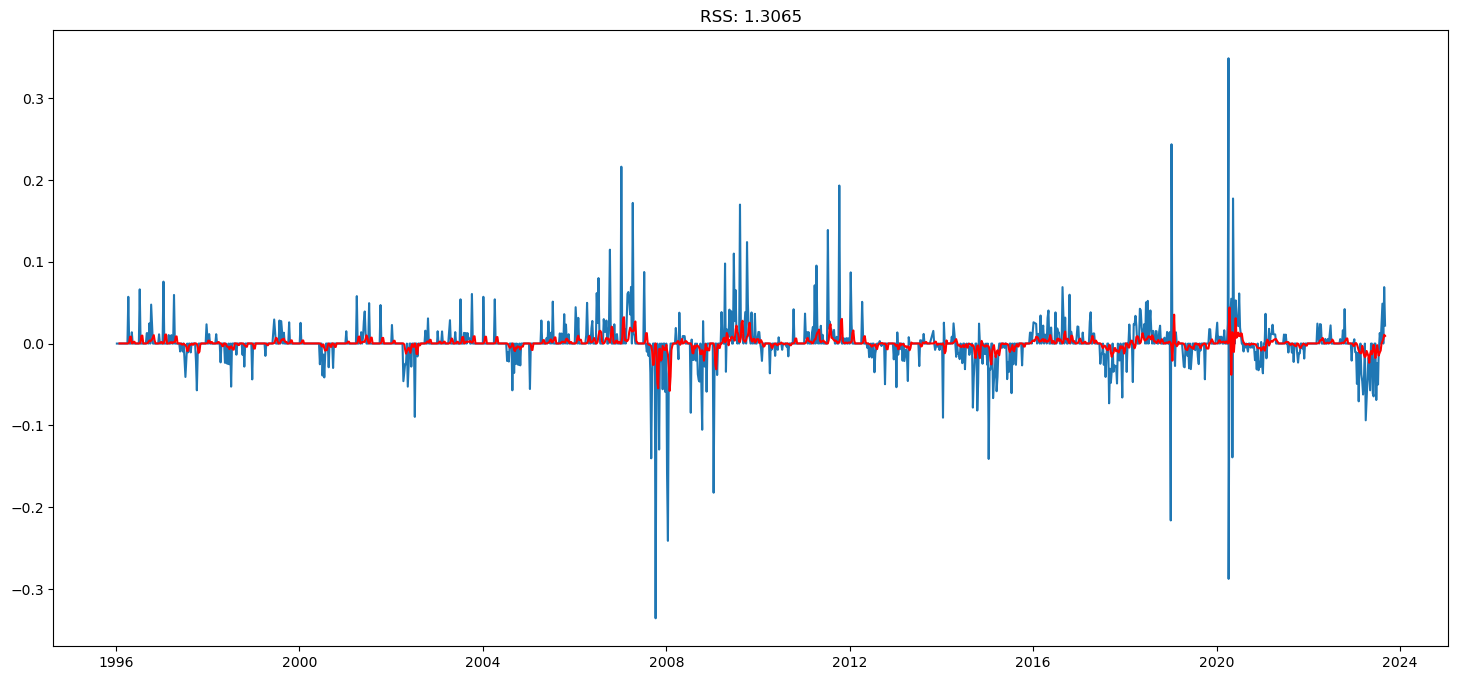

In [50]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Invertir las transformaciones

__Valores ajustados o predichos:__

In [51]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1996-01-29    0.000163
1996-02-05    0.000163
1996-02-12    0.000163
1996-02-19    0.000163
1996-02-26    0.000163
dtype: float64


__Suma acumulativa para invertir la diferenciación:__

In [52]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
1996-01-29    0.000163
1996-02-05    0.000326
1996-02-12    0.000489
1996-02-19    0.000652
1996-02-26    0.000815
dtype: float64


__Añadir el valor del primer mes que se eliminó anteriormente al diferenciar:__

In [54]:
predictions_ARIMA_log = pd.Series(ts_log[atri].iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1996-01-01   -1.786845
1996-01-08   -1.786845
1996-01-15   -1.786845
1996-01-22   -1.786845
1996-01-29   -1.786682
dtype: float64

__Tomando el exponente para invertir la transformación logarítmica:__

In [55]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 0.1784')

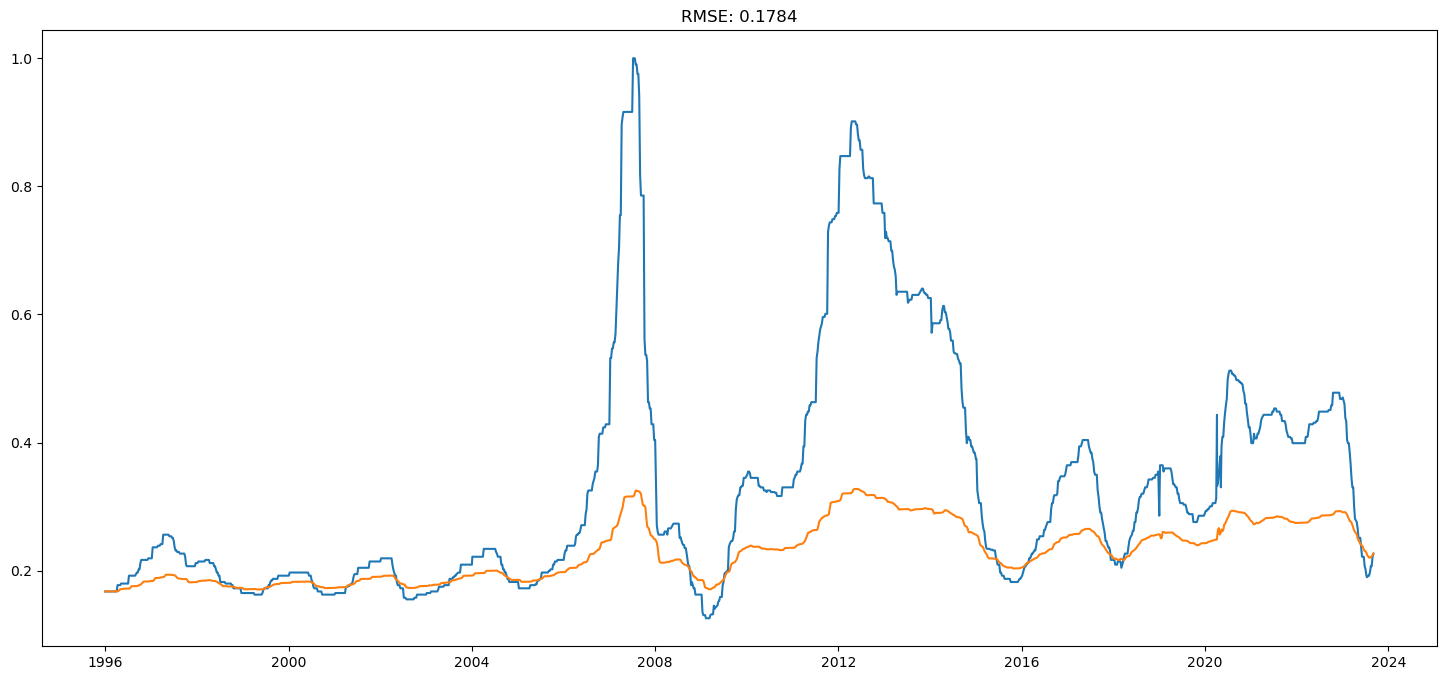

In [56]:
plt.plot(y[atri])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y[atri])**2)/len(y[atri])))

### Métricas de puntuación de la calidad de forecasting
- __R-cuadrado__
- __Mean Absolute Error__
- __Error absoluto medio__
- __Error medio cuadrado__
- __Error logarítmico al cuadrado medio__
- __Error de porcentaje absoluto medio__

In [57]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R squared__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1] 
- sklearn.metrics.r2_score

In [60]:
r2_score(y[atri], predictions_ARIMA)

0.08326199832482029

__Mean Absolute Error__
- sklearn.metrics.mean_absolute_error

In [62]:
mean_absolute_error(y[atri], predictions_ARIMA)

0.10775793524723831

__Median Absolute Error__
- sklearn.metrics.median_absolute_error

In [63]:
median_absolute_error(y[atri], predictions_ARIMA)

0.04378707855942417

__Mean Squared Error__
- sklearn.metrics.mean_squared_error


In [64]:
mean_squared_error(y[atri], predictions_ARIMA)

0.03182017329676343

__Mean Squared Logarithmic Error__, es similar al MSE but pero empleando el logaritmo de la serie, de esta forma se pone atención a los errores pequeños, se usa más en tendencias logaritmicas
- sklearn.metrics.mean_squared_log_error

In [65]:
mean_squared_log_error(y[atri], predictions_ARIMA)

0.014361912895030138

__Mean Absolute Percentage Error__, Es útil para explicar la calidad del modelo de forma entendible

In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [68]:
mean_absolute_percentage_error(y[atri], predictions_ARIMA)

22.876149544953634

Se define como función para facilitar su uso posterior

In [69]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [70]:
evaluate_forecast(y[atri], predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.083262,0.107758,0.043787,0.03182,0.014362,22.87615,0.178382


## Media móvil integrada autorregresiva (ARIMA)
En un modelo ARIMA hay 3 parámetros que se utilizan para ayudar a modelar los aspectos principales de una serie de tiempo: estacionalidad, tendencia y ruido. Estos parámetros se denominan p, d y q.

- __Número de términos AR (Auto-Regresivos) (p):__ p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, rezagos de la variable dependiente. Por ejemplo, si p es 5, los predictores de x (t) serán x (t-1)… .x (t-5).
- __Número de diferencias (d):__ d es el parámetro asociado con la parte integrada del modelo, que afecta la cantidad de diferenciación a aplicar a una serie de tiempo.
- __Número de términos MA (media móvil) (q):__ q es el tamaño de la ventana parcial de media móvil del modelo, es decir, errores de pronóstico retrasados ​​en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)… .e (t-5) donde e (i) es la diferencia entre la media móvil en iésimo instante y el valor real.


- La no estacionariedad implica que se requiere al menos un nivel de diferenciación (d) en ARIMA
- El siguiente paso es seleccionar los valores de retardo para los parámetros Autoregresión (AR) y Media móvil (MA), p y q respectivamente, usando gráficos PACF, ACF

Un problema con ARIMA es que no admite datos estacionales. Esa es una serie de tiempo con un ciclo que se repite. ARIMA espera datos que no sean estacionales o que tengan el componente estacional eliminado, p. Ej. ajustado estacionalmente mediante métodos como la diferenciación estacional.

In [74]:
ts = y[atri] - y[atri].shift()
ts.dropna(inplace=True)
ts

Date
1996-01-08    0.000000
1996-01-15    0.000000
1996-01-22    0.000000
1996-01-29    0.000000
1996-02-05    0.000000
                ...   
2023-08-07    0.004926
2023-08-14    0.009852
2023-08-21    0.000000
2023-08-28    0.014778
2023-09-04    0.004926
Name: Lactose, Length: 1435, dtype: float64

__Gráficas de ACF y PACF después de la diferenciación:__

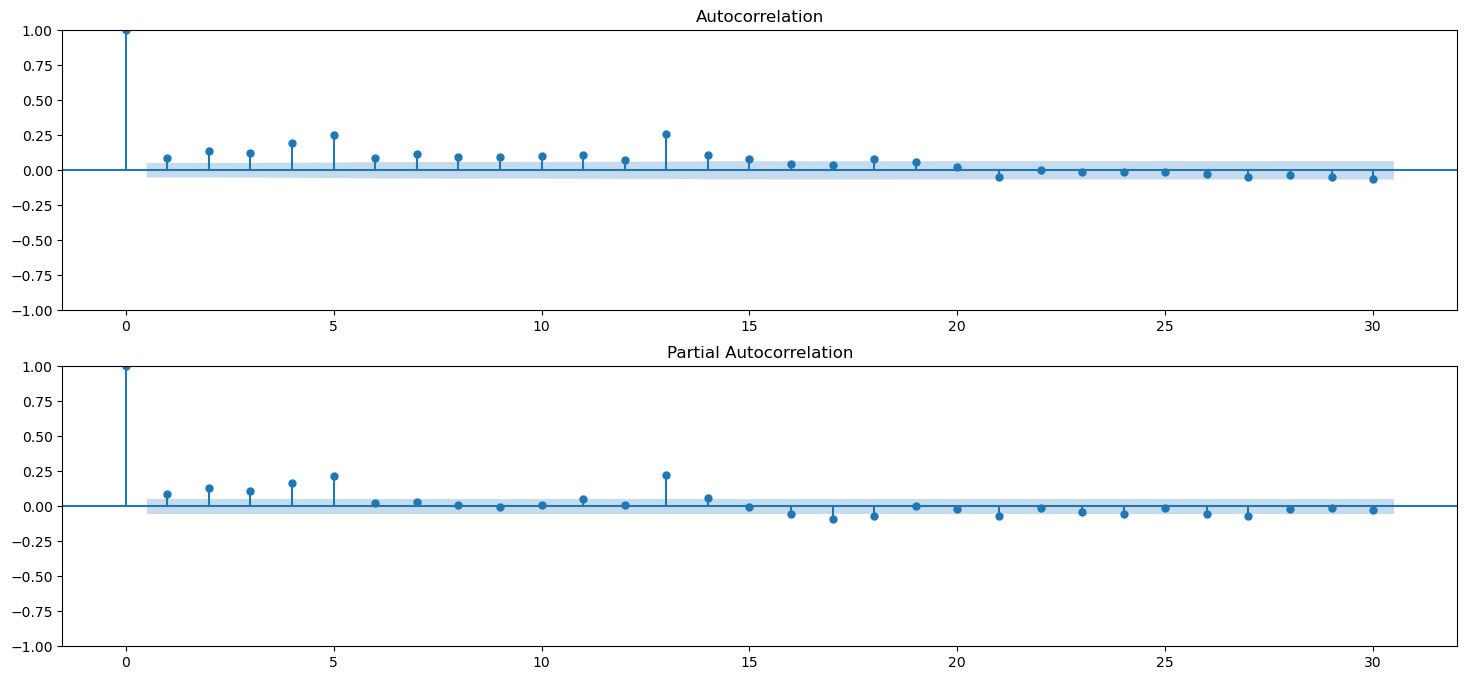

In [76]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

## Interpretación de gráficos ACF

* Nota: esta tabla es tomada de la bibliografía consultada, no es de autoría propia.

ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |

In [83]:
ts_log_diff_c = ts_log_diff.copy()
ts_log_diff_c

Date
1996-01-08    0.000000
1996-01-15    0.000000
1996-01-22    0.000000
1996-01-29    0.000000
1996-02-05    0.000000
                ...   
2023-08-07    0.025318
2023-08-14    0.048790
2023-08-21    0.000000
2023-08-28    0.068993
2023-09-04    0.021979
Name: Lactose, Length: 1435, dtype: float64

In [84]:
ts_log_diff_c = pd.DataFrame(ts_log_diff_c)
ts_log_diff_c

,Lactose
Date,
1996-01-08,0.000000
1996-01-15,0.000000
1996-01-22,0.000000
1996-01-29,0.000000
1996-02-05,0.000000
...,...
2023-08-07,0.025318
2023-08-14,0.048790
2023-08-21,0.000000


In [85]:
# Dividir en conjunto de entrenamiento y prueba
ts_log_diff_c.index = pd.DatetimeIndex(ts_log_diff_c.index).to_period('W')
train = ts_log_diff_c[:int(0.75*(len(ts_log_diff_c)))]
valid = ts_log_diff_c[int(0.75*(len(ts_log_diff_c))):]
train

,Lactose
Date,
1996-01-08/1996-01-14,0.000000
1996-01-15/1996-01-21,0.000000
1996-01-22/1996-01-28,0.000000
1996-01-29/1996-02-04,0.000000
1996-02-05/1996-02-11,0.000000
...,...
2016-08-22/2016-08-28,0.068993
2016-08-29/2016-09-04,0.032790
2016-09-05/2016-09-11,0.000000


In [ ]:
#train.index = pd.DatetimeIndex(train.index).to_period('W')
#train

In [ ]:
#valid.index = pd.DatetimeIndex(valid.index).to_period('W')
#valid

<AxesSubplot: xlabel='Date'>

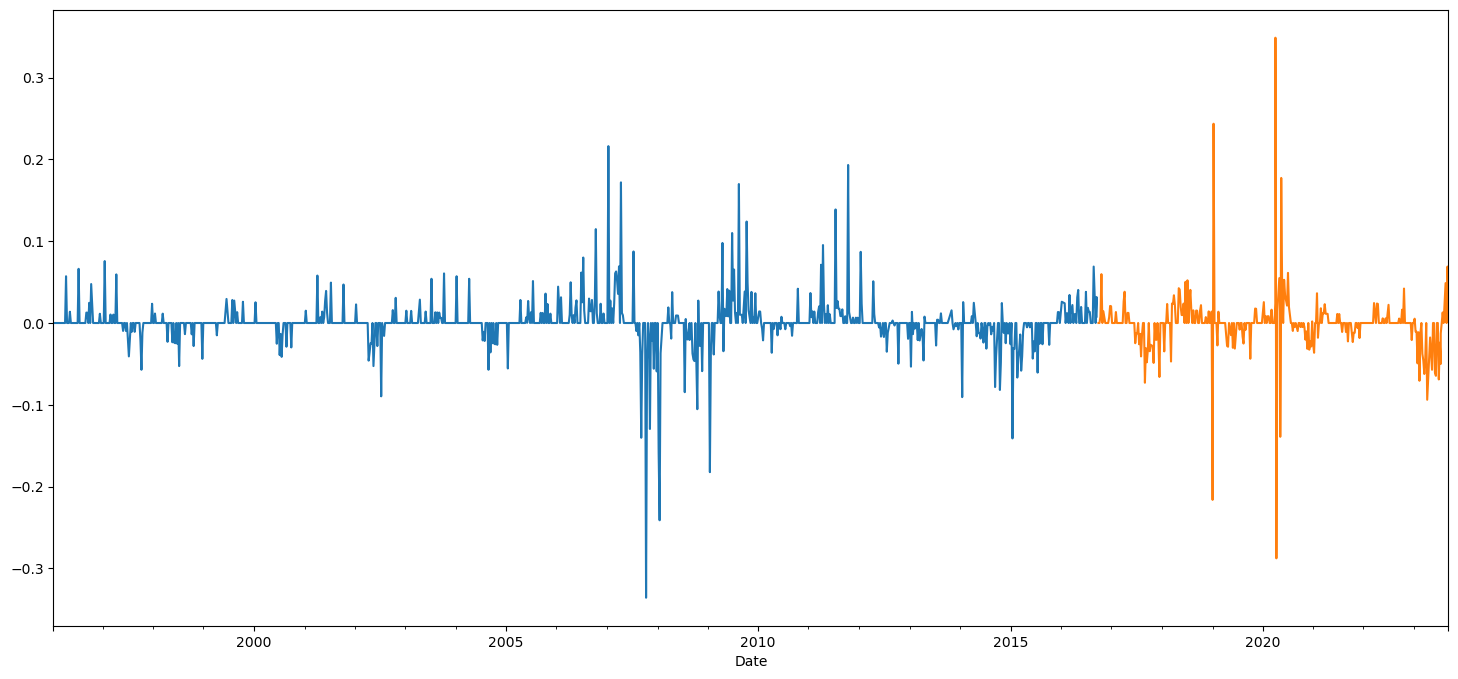

In [88]:
#plotting the data
train[atri].plot()
valid[atri].plot()

In [89]:
# ARIMA 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Entrenar
model = sm.tsa.arima.ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

In [90]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Lactose   No. Observations:                 1076
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2388.797
Date:                Fri, 01 Dec 2023   AIC                          -4769.594
Time:                        08:53:29   BIC                          -4749.670
Sample:                    01-14-1996   HQIC                         -4762.049
                         - 09-18-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.280      0.779      -0.005       0.007
ar.L1          0.9575      0.012     79.510      0.000       0.934       0.981
ma.L1         -0.8474      0.022    -37.944      0.000      -0.891      -0.804
sigma2         0.0007   8.39e-06     82.261      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             64381.50
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                            -1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
start_index = valid.index.min()
end_index = valid.index.max()

# Predicciones
predictions = model_fit.predict(start=start_index, end=end_index)

In [92]:
forecastx = pd.DataFrame(predictions,index = valid.index,columns=['predicted_mean'])
forecastx

,predicted_mean
Date,
2016-09-26/2016-10-02,0.010189
2016-10-03/2016-10-09,0.009793
2016-10-10/2016-10-16,0.009414
2016-10-17/2016-10-23,0.009051
2016-10-24/2016-10-30,0.008704
...,...
2023-08-07/2023-08-13,0.000868
2023-08-14/2023-08-20,0.000868
2023-08-21/2023-08-27,0.000868


In [94]:
# RMSE
mse = mean_squared_error(ts_log_diff_c[start_index:end_index], forecastx)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 0.037981342954444074, MSE:0.0014425824126230984


In [ ]:
#y_true = pd.DataFrame(y,index = y.index,columns=[atri])
#y_true

Text(0.5, 1.0, 'RMSE: 0.0380')

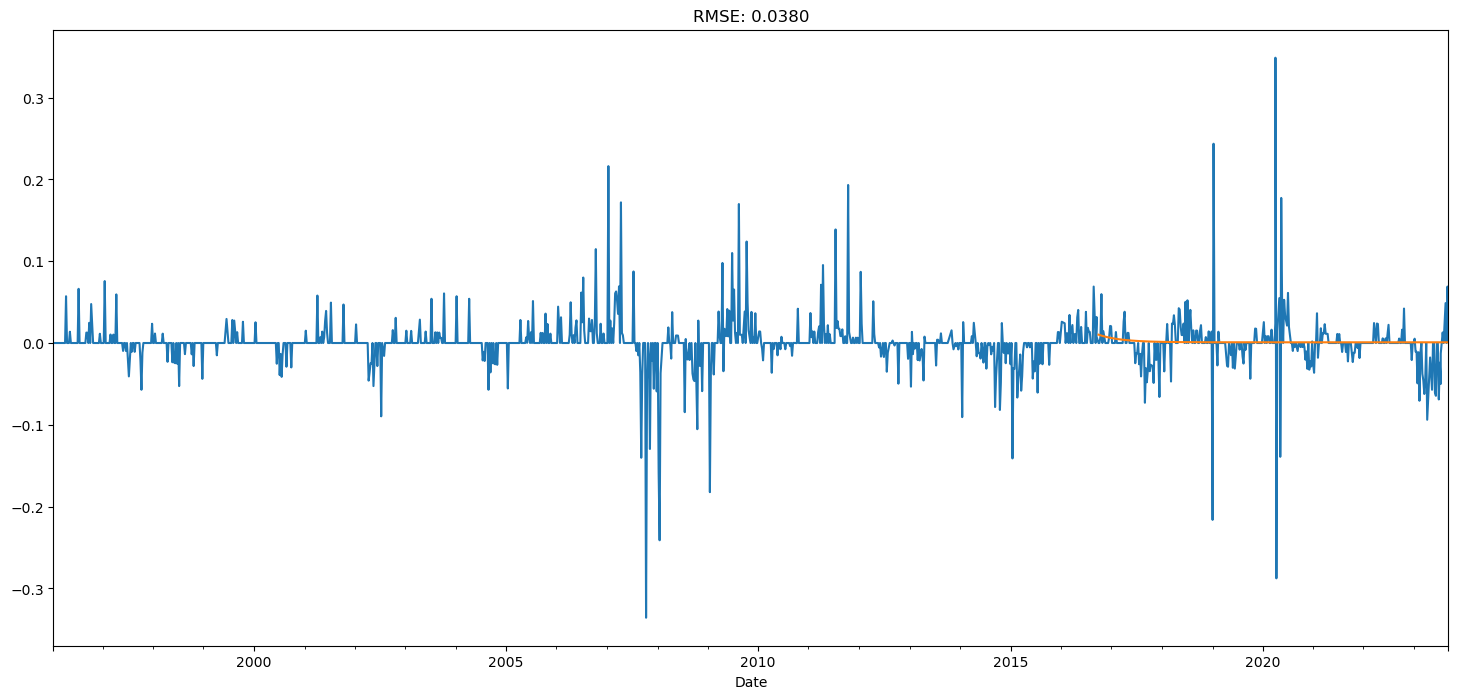

In [95]:
ts_log_diff_c[atri].plot()
forecastx['predicted_mean'].plot()
plt.title('RMSE: %.4f'% rmse)

__Valores ajustados o predichos:__

In [96]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

2016-09-26/2016-10-02    0.010189
2016-10-03/2016-10-09    0.009793
2016-10-10/2016-10-16    0.009414
2016-10-17/2016-10-23    0.009051
2016-10-24/2016-10-30    0.008704
Freq: W-SUN, Name: predicted_mean, dtype: float64


__Suma acumulativa para invertir la diferenciación:__

In [97]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

2016-09-26/2016-10-02    0.010189
2016-10-03/2016-10-09    0.019983
2016-10-10/2016-10-16    0.029397
2016-10-17/2016-10-23    0.038448
2016-10-24/2016-10-30    0.047152
Freq: W-SUN, Name: predicted_mean, dtype: float64


__Añadir el valor del primer mes que se eliminó anteriormente al diferenciar:__

In [98]:
predictions_ARIMA_log = pd.Series(valid[atri].iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

2016-09-26/2016-10-02    0.010189
2016-10-03/2016-10-09    0.019983
2016-10-10/2016-10-16    0.029397
2016-10-17/2016-10-23    0.038448
2016-10-24/2016-10-30    0.047152
Freq: W-SUN, dtype: float64

__Tomando exponente para invertir la transformación logarítmica:__

<AxesSubplot: xlabel='Date'>

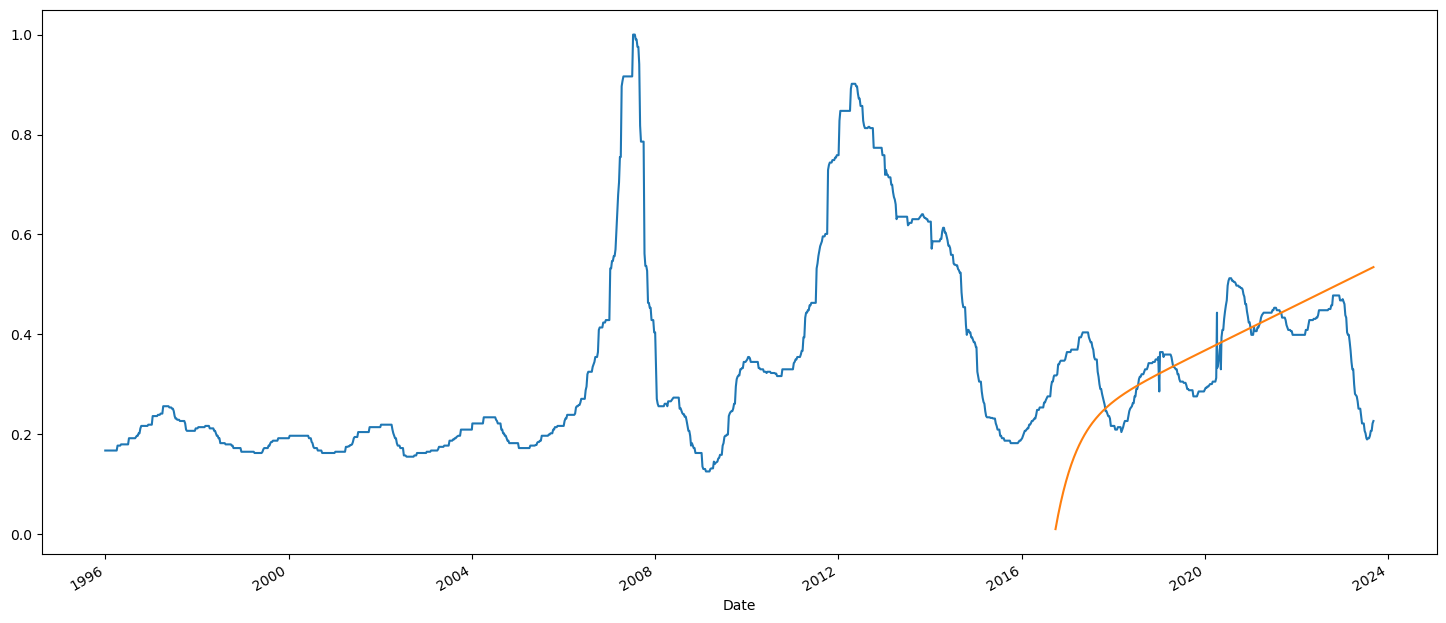

In [108]:
#y[atri].plot()
#predictions_ARIMA_log.plot()
#plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))
y[atri].plot()
predictions_ARIMA_log.plot()
#plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [110]:
y_c = y.copy()
y_c.index = pd.DatetimeIndex(y_c.index).to_period('W')
y_c

,Lactose
Date,
1996-01-01/1996-01-07,0.167488
1996-01-08/1996-01-14,0.167488
1996-01-15/1996-01-21,0.167488
1996-01-22/1996-01-28,0.167488
1996-01-29/1996-02-04,0.167488
...,...
2023-08-07/2023-08-13,0.197044
2023-08-14/2023-08-20,0.206897
2023-08-21/2023-08-27,0.206897


In [114]:
predictions_ARIMA_log_c = pd.DataFrame(predictions_ARIMA_log, columns=['predicted_mean'])
predictions_ARIMA_log_c

,predicted_mean
2016-09-26/2016-10-02,0.010189
2016-10-03/2016-10-09,0.019983
2016-10-10/2016-10-16,0.029397
2016-10-17/2016-10-23,0.038448
2016-10-24/2016-10-30,0.047152
...,...
2023-08-07/2023-08-13,0.531123
2023-08-14/2023-08-20,0.531992
2023-08-21/2023-08-27,0.532860
2023-08-28/2023-09-03,0.533728


In [115]:
evaluate_forecast(y_c[start_index:end_index], predictions_ARIMA_log_c)

ValueError: Found input variables with inconsistent numbers of samples: [359, 366]

In [119]:
evaluate_forecast(y_c[start_index:end_index], predictions_ARIMA_log)

ValueError: Found input variables with inconsistent numbers of samples: [359, 366]